## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score

import os
import joblib

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

random_state = 4012

## 2. Load Data

In [2]:
X_train = pd.read_csv("../Processed Data Files/X_train.csv")
y_train = pd.read_csv("../Processed Data Files/y_train.csv")

## 3. Model

In [10]:
# Combine them!

scaler = StandardScaler()

onehot = OneHotEncoder(
    categories = [
            ['full time', 'contract', 'part time','flexi','other','unspecified'], # employment_type
            ['entry level', 'middle level', 'senior level', 'unspecified'], # required_experience
            ['high school or vocational degree', 'undergraduate', 'graduate', 'unspecified'], # required_education
    ],
    handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

freq_encoder = CountEncoder()

binary_columns = ['telecommuting', 'has_company_logo','has_questions', 'have_company_profile', 'have_requirements', 'have_benefits', 'have_category', 'high_salary']
numerical_columns = ['flesch_score_bin_ft','fk_grade_level_bin_ft', 'text_len']
onehot_columns = ['employment_type', 'required_experience','required_education']
freq_columns = ['location_country']

preprocessor = ColumnTransformer([
    # (nickname, transformer to apply, columns to apply to)
    ('binary', 'passthrough', binary_columns),  # <- 'passthrough' says to keep them but don't apply anything
    ('numerical', scaler, numerical_columns),   
    ('onehot', onehot, onehot_columns),
    ('frequency',freq_encoder, freq_columns),
],  remainder='passthrough')

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    # ('resampling', SMOTEENN(random_state=random_state,enn=EditedNearestNeighbours(sampling_strategy='majority'))),
    ('train', CatBoostClassifier(random_state=random_state)),
])

params = dict(
    train__n_estimators = [100, 200, 300],
    train__learning_rate = [0.1, 0.3, 0.5],
    train__max_depth = [4, 6, 8],
    train__l2_leaf_reg = [1, 5, 10],
    train__border_count = [32, 64, 128],
    train__loss_function = ['Logloss', 'CrossEntropy'],
    train__auto_class_weights = ['Balanced']
)


def train(x_train, y_train, model, params):
    
    gridsearchcv = GridSearchCV(model, params, cv=5, scoring='f1_weighted', verbose=3, n_jobs=-1)
    gridsearchcv.fit(x_train, y_train.values)
    
    best_model = model.set_params(**gridsearchcv.best_params_).fit(x_train, y_train.values)
    

    return best_model, gridsearchcv.best_params_


best_model, best_params = train(X_train, y_train, model, params)

print("Best Parameters:", best_params)

#Best Parameters: {'train__n_estimators': 300, 'train__max_depth': 4, 'train__loss_function': 'Logloss', 'train__learning_rate': 0.1, 'train__l2_leaf_reg': 5, 'train__border_count': 64, 'train__auto_class_weights': 'Balanced'}

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
0:	learn: 0.6198321	total: 20.2ms	remaining: 6.04s
1:	learn: 0.5526802	total: 39.2ms	remaining: 5.84s
2:	learn: 0.4982758	total: 58ms	remaining: 5.74s
3:	learn: 0.4632869	total: 75ms	remaining: 5.55s
4:	learn: 0.4253447	total: 94.5ms	remaining: 5.58s
5:	learn: 0.3945607	total: 114ms	remaining: 5.57s
6:	learn: 0.3754273	total: 132ms	remaining: 5.52s
7:	learn: 0.3625220	total: 150ms	remaining: 5.48s
8:	learn: 0.3486589	total: 171ms	remaining: 5.52s
9:	learn: 0.3381626	total: 194ms	remaining: 5.61s
10:	learn: 0.3273224	total: 214ms	remaining: 5.62s
11:	learn: 0.3197927	total: 237ms	remaining: 5.68s
12:	learn: 0.3123993	total: 258ms	remaining: 5.7s
13:	learn: 0.3037355	total: 280ms	remaining: 5.71s
14:	learn: 0.2977647	total: 299ms	remaining: 5.67s
15:	learn: 0.2834979	total: 317ms	remaining: 5.63s
16:	learn: 0.2796563	total: 336ms	remaining: 5.59s
17:	learn: 0.2734110	total: 355ms	remaining: 5.56s
18:	learn: 0.2690323	total: 

168:	learn: 0.0410427	total: 3.22s	remaining: 2.49s
169:	learn: 0.0406632	total: 3.23s	remaining: 2.47s
170:	learn: 0.0402161	total: 3.25s	remaining: 2.46s
171:	learn: 0.0396124	total: 3.28s	remaining: 2.44s
172:	learn: 0.0392110	total: 3.29s	remaining: 2.42s
173:	learn: 0.0388616	total: 3.31s	remaining: 2.4s
174:	learn: 0.0386218	total: 3.33s	remaining: 2.38s
175:	learn: 0.0382132	total: 3.35s	remaining: 2.36s
176:	learn: 0.0377594	total: 3.37s	remaining: 2.34s
177:	learn: 0.0373879	total: 3.39s	remaining: 2.32s
178:	learn: 0.0369171	total: 3.4s	remaining: 2.3s
179:	learn: 0.0364412	total: 3.42s	remaining: 2.28s
180:	learn: 0.0361968	total: 3.44s	remaining: 2.26s
181:	learn: 0.0357649	total: 3.46s	remaining: 2.24s
182:	learn: 0.0354104	total: 3.47s	remaining: 2.22s
183:	learn: 0.0350364	total: 3.49s	remaining: 2.2s
184:	learn: 0.0347151	total: 3.51s	remaining: 2.18s
185:	learn: 0.0342591	total: 3.53s	remaining: 2.16s
186:	learn: 0.0339454	total: 3.54s	remaining: 2.14s
187:	learn: 0.03

36:	learn: 0.1994220	total: 686ms	remaining: 4.87s
37:	learn: 0.1969575	total: 703ms	remaining: 4.85s
38:	learn: 0.1952665	total: 720ms	remaining: 4.82s
39:	learn: 0.1930018	total: 738ms	remaining: 4.8s
40:	learn: 0.1901922	total: 756ms	remaining: 4.78s
41:	learn: 0.1877297	total: 773ms	remaining: 4.75s
42:	learn: 0.1852421	total: 791ms	remaining: 4.73s
43:	learn: 0.1826634	total: 810ms	remaining: 4.71s
44:	learn: 0.1796771	total: 826ms	remaining: 4.68s
45:	learn: 0.1774121	total: 845ms	remaining: 4.67s
46:	learn: 0.1752649	total: 862ms	remaining: 4.64s
47:	learn: 0.1734882	total: 877ms	remaining: 4.61s
48:	learn: 0.1718921	total: 896ms	remaining: 4.59s
49:	learn: 0.1699809	total: 915ms	remaining: 4.58s
50:	learn: 0.1684600	total: 932ms	remaining: 4.55s
51:	learn: 0.1664028	total: 949ms	remaining: 4.53s
52:	learn: 0.1636251	total: 967ms	remaining: 4.5s
53:	learn: 0.1622092	total: 984ms	remaining: 4.48s
54:	learn: 0.1602419	total: 1s	remaining: 4.46s
55:	learn: 0.1590487	total: 1.02s	re

197:	learn: 0.0303806	total: 3.52s	remaining: 1.81s
198:	learn: 0.0301219	total: 3.53s	remaining: 1.79s
199:	learn: 0.0297849	total: 3.55s	remaining: 1.77s
200:	learn: 0.0295243	total: 3.56s	remaining: 1.76s
201:	learn: 0.0292263	total: 3.58s	remaining: 1.74s
202:	learn: 0.0289348	total: 3.6s	remaining: 1.72s
203:	learn: 0.0286565	total: 3.61s	remaining: 1.7s
204:	learn: 0.0282526	total: 3.63s	remaining: 1.68s
205:	learn: 0.0279709	total: 3.65s	remaining: 1.67s
206:	learn: 0.0276734	total: 3.67s	remaining: 1.65s
207:	learn: 0.0273325	total: 3.69s	remaining: 1.63s
208:	learn: 0.0270739	total: 3.7s	remaining: 1.61s
209:	learn: 0.0267665	total: 3.72s	remaining: 1.59s
210:	learn: 0.0264953	total: 3.74s	remaining: 1.58s
211:	learn: 0.0263732	total: 3.75s	remaining: 1.56s
212:	learn: 0.0261583	total: 3.77s	remaining: 1.54s
213:	learn: 0.0259059	total: 3.79s	remaining: 1.52s
214:	learn: 0.0255654	total: 3.8s	remaining: 1.5s
215:	learn: 0.0252624	total: 3.82s	remaining: 1.49s
216:	learn: 0.025

In [12]:
base_path = "../Models/" # path where the file is going to be saved in 

model_name = 'catboost'

model_path = os.path.join(base_path, f'{model_name}.joblib')

joblib.dump(best_model, model_path)

['../Models/catboost.joblib']

### Feature Importance

In [13]:
catboost_model = best_model.named_steps['train']

feature_importances = catboost_model.get_feature_importance()

def get_feature_names(column_transformer):
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            output_features.extend(features)
        elif isinstance(pipe, OneHotEncoder):
            for feature, categories in zip(features, pipe.categories_):
                output_features.extend([f"{feature}_{category}" for category in categories])
        elif isinstance(pipe, CountEncoder):
            output_features.extend(features)
        else:
            output_features.extend(features)

    return output_features

feature_names = get_feature_names(preprocessor)

In [14]:
if len(feature_importances) == len(feature_names):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(importance_df)

                  Feature  Importance
25       location_country    5.724426
10               text_len    4.458953
3    have_company_profile    4.288295
1        has_company_logo    3.162032
4       have_requirements    2.906992
..                    ...         ...
214                   203    0.000000
208                   197    0.000000
385                   374    0.000000
591                   580    0.000000
71                     60    0.000000

[794 rows x 2 columns]


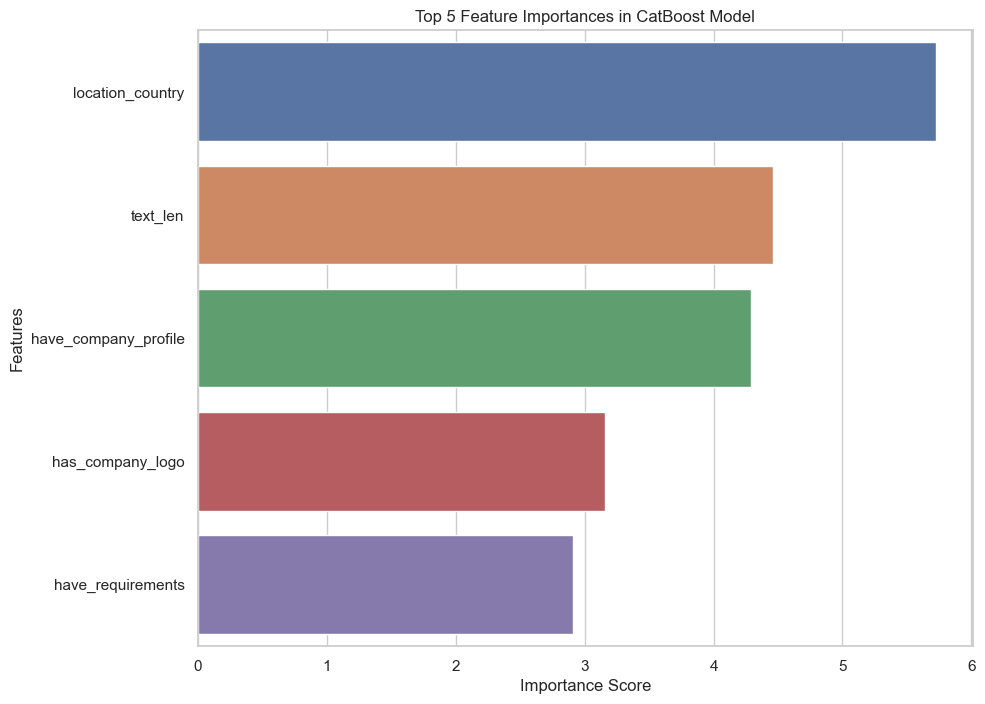

In [15]:
top_features = importance_df.sort_values(by='Importance', ascending=False).head(5)

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

sns.barplot(x="Importance", y="Feature", data=top_features)

plt.title('Top 5 Feature Importances in CatBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()